<a href="https://colab.research.google.com/github/Kakumanu-Harshitha/Room-Temperature-Prediction/blob/main/Room_Temperature_prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 2.Import Dataset

In [ ]:
df=pd.read_csv('MLTempDataset.csv')

In [ ]:
df.head()

,Unnamed: 0,Datetime1,DAYTON_MW,Datetime
0,0,0,20.867,2022-01-04 00:00:00
1,1,1,21.000,2022-01-04 01:00:00
2,2,2,20.867,2022-01-04 02:00:00
3,3,3,20.650,2022-01-04 03:00:00
4,4,4,20.400,2022-01-04 04:00:00


Drop the Features which are not useful for building the model

In [ ]:
df.drop(['Unnamed: 0', 'Datetime1'],axis= 1,inplace=True)

'Datetime' feature from the dataset is in the object data type so lets change it into date type.

In [ ]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Datetime']

,Datetime
0,2022-01-04 00:00:00
1,2022-01-04 01:00:00
2,2022-01-04 02:00:00
3,2022-01-04 03:00:00
4,2022-01-04 04:00:00
...,...
6671,2022-10-08 23:00:00
6672,2022-10-09 00:00:00
6673,2022-10-09 01:00:00
6674,2022-10-09 02:00:00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6676 entries, 0 to 6675
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   DAYTON_MW  6676 non-null   float64       
 1   Datetime   6676 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 104.4 KB


# 3.Data Preprocessing

In [ ]:
df.isnull().sum()

,0
DAYTON_MW,0
Datetime,0


make sure that whether the date and time is arranged in the order.

In [ ]:
df = df.sort_values('Datetime')
df

,DAYTON_MW,Datetime
0,20.867,2022-01-04 00:00:00
1,21.000,2022-01-04 01:00:00
2,20.867,2022-01-04 02:00:00
3,20.650,2022-01-04 03:00:00
4,20.400,2022-01-04 04:00:00
...,...,...
6671,27.350,2022-10-08 23:00:00
6672,26.800,2022-10-09 00:00:00
6673,26.450,2022-10-09 01:00:00
6674,25.900,2022-10-09 02:00:00


In [ ]:
len(df)

6676

In [ ]:
data=df[['DAYTON_MW']]

# Split into train and test data

split the dataset into 80% train data and 20% test data

In [ ]:
train_size = int(len(df['DAYTON_MW']) * 0.8)
train_data,test_data=data[:train_size],data[train_size:]
test_dates=df['Datetime'][train_size:]

# Feature Scaling

Here I used MinMaxScaler to scale the records between the range 0 to 1.For the better performance.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data=scaler.transform(test_data)



# Create Dataset

The create_dataset function converts a time series dataset into a supervised learning format by generating input-output pairs. It uses a sliding window approach, where the past look_back time steps are used as input features (X), and the next time step is the target value (Y). This method is commonly used for time series forecasting tasks, enabling models to learn temporal patterns.



In [ ]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])  # Ensure slicing is applied to the first column
        Y.append(dataset[i + look_back, 0])     # Target value
    return np.array(X), np.array(Y)


In [ ]:
look_back=10
X_train,Y_train=create_dataset(scaled_train_data,look_back )
X_test,Y_test=create_dataset(scaled_test_data,look_back )

In [ ]:
X_train

array([[0.49813804, 0.5024077 , 0.49813804, ..., 0.45425361, 0.45104334,
        0.45425361],
       [0.5024077 , 0.49813804, 0.49117175, ..., 0.45104334, 0.45425361,
        0.46815409],
       [0.49813804, 0.49117175, 0.48314607, ..., 0.45425361, 0.46815409,
        0.49438202],
       ...,
       [0.62760835, 0.62760835, 0.62760835, ..., 0.61316212, 0.60834671,
        0.60407705],
       [0.62760835, 0.62760835, 0.62953451, ..., 0.60834671, 0.60407705,
        0.6       ],
       [0.62760835, 0.62953451, 0.62866774, ..., 0.60407705, 0.6       ,
        0.59656501]])

In [ ]:
X_train.shape

(5330, 10)

# Changing X into Correct Format

When we pass it into LSTM neural network it must be 3 Dimensional.

In [ ]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)


# Build the Model

**Create model**: To predict Room Temperature we need to use recurrent nueral networks. So that we can use LSTM which have a good structure.LSTM-Long Short term memory. To maintain and remember all the historic values LSTM layer is good. At last we need to predict the price so we can use dense layer.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.fit(X_train, Y_train, epochs=10, batch_size=1, verbose=1, validation_data=(X_test, Y_test))

Epoch 1/10
5330/5330 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - loss: 0.0092 - val_loss: 0.0025
Epoch 2/10
5330/5330 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - loss: 0.0091 - val_loss: 0.0031
Epoch 3/10
5330/5330 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - loss: 0.0087 - val_loss: 0.0041
Epoch 4/10
5330/5330 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - loss: 0.0082 - val_loss: 0.0025
Epoch 5/10
5330/5330 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 0.0091 - val_loss: 0.0029
Epoch 6/10
5330/5330 ━━━━━━━━━━━━━━━━━━━━ 85s 8ms/step - loss: 0.0075 - val_loss: 0.0038
Epoch 7/10
5330/5330 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - loss: 0.0083 - val_loss: 0.0025
Epoch 8/10
5330/5330 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - loss: 0.0080 - val_loss: 0.0025
Epoch 9/10
5330/5330 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - loss: 0.0079 - val_loss: 0.0050
Epoch 10/10
5330/5330 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - loss: 0.0090 - val_loss: 0.0024


In [ ]:
model.evaluate(X_test, Y_test)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0016


0.0024391955230385065

# Predict the Model

In [81]:
test_predictions = model.predict(X_test)

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [82]:
y_pred=scaler.inverse_transform(test_predictions.reshape(-1,1))
y_test=scaler.inverse_transform(Y_test.reshape(-1,1))

In [83]:
from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

0.8879051335800001

# Final DataFrame

Lets compare the values by creating dataframe for actual and predicted values.

In [84]:
dataframe=pd.DataFrame()
dataframe['Datetime']=test_dates[look_back:]
dataframe['Actual']=y_test
dataframe['Predicted']=y_pred

In [85]:
dataframe

,Datetime,Actual,Predicted
5350,2022-08-14 22:00:00,22.100,22.052296
5351,2022-08-14 23:00:00,22.100,22.030474
5352,2022-08-15 00:00:00,22.217,22.045965
5353,2022-08-15 01:00:00,22.420,22.219757
5354,2022-08-15 02:00:00,22.300,22.442400
...,...,...,...
6671,2022-10-08 23:00:00,27.350,27.430775
6672,2022-10-09 00:00:00,26.800,26.743341
6673,2022-10-09 01:00:00,26.450,26.388510
6674,2022-10-09 02:00:00,25.900,26.205833


# Vizualize Actual vs predicted values

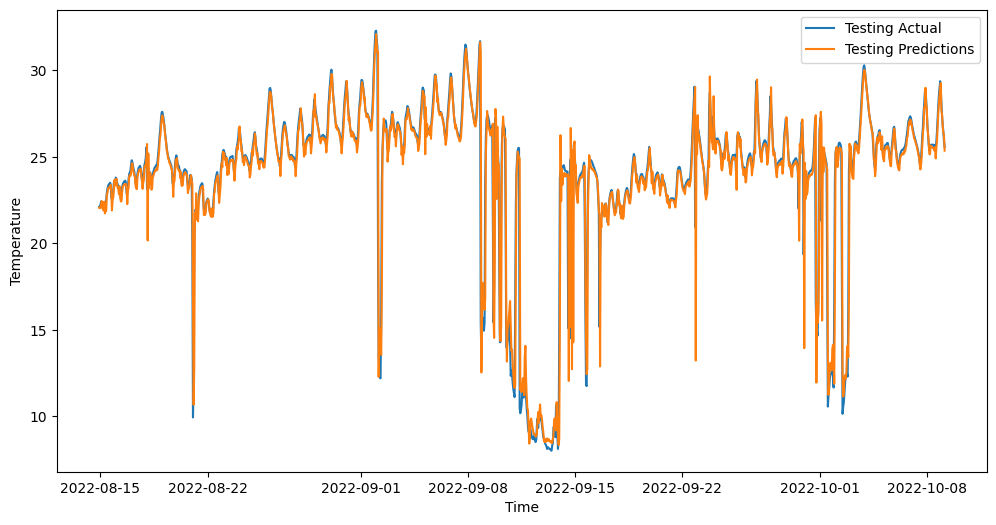

In [86]:
plt.figure(figsize=(12, 6))
plt.plot(df['Datetime'][train_size + look_back:], y_test, label='Testing Actual')
plt.plot(df['Datetime'][train_size + look_back:], y_pred, label='Testing Predictions')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()